In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import tqdm as tq
from datetime import datetime,timedelta
from colorama import Fore, Back, Style
import glob 
import os

class tracking_analysis:

    def __init__(self):

        self.path = None
        self.list_filenames = None 
        self.animal = None
        self.progress_bar = None
        self.light_on = [datetime(2019, 8, 3, 6, 0, 24, 69), datetime(2019, 8, 4, 6, 0, 27, 89), datetime(2019, 8, 5, 6, 0, 23, 48)] # None
        self.dataSet_all = pd.DataFrame([])

    def strtomonth(self, mes):
        if mes == "Jan":  monthNUM = 1;
        elif mes == "Feb":  monthNUM = 2;
        elif mes == "Mar":  monthNUM = 3;
        elif mes == "Apr":  monthNUM = 4;
        elif mes == "May":  monthNUM = 5;
        elif mes == "Jun":  monthNUM = 6;
        elif mes == "Jul":  monthNUM = 7;
        elif mes == "Aug":  monthNUM = 8;
        elif mes == "Sep":  monthNUM = 9;
        elif mes == "Oct": monthNUM = 10;
        elif mes == "Nov": monthNUM = 11;
        elif mes == "Dec": monthNUM = 12;
        else: print('invalid');
        return monthNUM

    def get_dir_list(self):
        list_folders = sorted(glob.glob(self.path + "/*/"))
        list_filenames = np.array([])
        
        for folder in list_folders:
            filenames = glob.glob(os.path.join(folder, "*.csv"))
            self.animal = filenames[1][-30:-25]
            
            list_filenames = np.hstack([list_filenames, filenames])
            
        self.list_filenames = sorted(list_filenames)

    def checking_light(self):
        # 0 declarando variavies -------------------------------------------------------------------------------------------
        coord = np.array([])
        luz = True
        self.light_on = []

        for k,j in enumerate(self.list_filenames): ## for geral que irá caminhar por cada filename
            
            # 1 lendo filename ---------------------------------------------------------------------------------------------
            filename = j
            dataSet = pd.read_csv(filename,names = ['a','b','c','d','e','f','g']) ## lendo filename
            dataSet_np = np.array(dataSet) ## transformando em numpy array para ganhar velocidade de processamento
            # --------------------------------------------------------------------------------------------------------------
            
            # 2 separando os dados de tempo e coordenada -------------------------------------------------------------------
            timet = dataSet_np[:,4:] 
            coord = dataSet_np[:,1:3]
            # --------------------------------------------------------------------------------------------------------------
            
            for i in range(len(timet)): ## for que irá caminhar por cada linha da tabela lida
                
                # 3 extraindo os dados de tempo ----------------------------------------------------------------------------
                ano = int(filename[len(filename)-17:len(filename)-13])
                mes = int(self.strtomonth(filename[len(filename)-21:len(filename)-18]))
                dia = int(filename[len(filename)-24:len(filename)-22])
                hora = int(timet[i,0])
                minu = int(timet[i,1])
                seg = int(timet[i,2])
                mics = int(100*(dataSet_np[i,6]%1))
                # ---------------------------------------------------------------------------------------------------------- 
            
                # 4 checando ligar/desligar da luz -------------------------------------------------------------------------
                if coord[i,0] == 160.5 and coord[i,1] == 120.5 and luz == True:
                    print(Back.BLACK + Fore.WHITE + " OFF →", datetime(ano,mes,dia,hora,minu,seg), "", filename, "")
                    luz = False

                elif coord[i,0] != 160.5 and coord[i,1] != 120.5 and luz == False:
                    print(Back.WHITE + Fore.BLACK + " ON  →", datetime(ano,mes,dia,hora,minu,seg), "", filename, "")
                    
                    self.light_on.append(datetime(ano,mes,dia,hora,minu,seg,mics))
                    luz = True
                # ----------------------------------------------------------------------------------------------------------
       
            self.progress_bar.progress((k+1)/len(self.list_filenames))
        


    def get_heatmap_df(self):
        
        # 0 declarando variavies -------------------------------------------------------------------------------------------
        quinze_horas = datetime(2019,8,14,21,0,0) - datetime(2019,8,14,6,0,0,0)

        td30m = timedelta(minutes=30, hours=0)
        td1h = timedelta(minutes=0, hours=1)
        td2h = timedelta(minutes=0, hours=2)
        td3h = timedelta(minutes=0, hours=3)
        td5h = timedelta(minutes=0, hours=5)
        td7h30m = timedelta(minutes=30, hours=7)

        list30m = []
        list1h = []
        list2h = []
        list3h = []
        list5h = []
        list7h30m = []
        list_day = []

        format_data = "%d/%m/%y %H:%M:%S"

        last_day = False
        begin = False
        on = 0

        dia_check = 0 
        mes_check = 0

        for j, filename in enumerate(tq.tqdm(self.list_filenames)): ## for geral que irá caminhar por cada filename
            
            # 1 lendo filename ---------------------------------------------------------------------------------------------
            dataSet = pd.read_csv(filename,names = ['update_rate','coord_x','coord_y','x','time_h','time_m','time_s']) ## lendo filename
            self.dataSet_all = pd.concat([self.dataSet_all, dataSet])
            dataSet_np = np.array(dataSet) ## transformando em numpy array para ganhar velocidade de processamento
            # --------------------------------------------------------------------------------------------------------------
            
            # 2 separando os dados de tempo e coordenada -------------------------------------------------------------------
            timet = dataSet_np[:,4:] 
            coord = dataSet_np[:,1:3]
            # --------------------------------------------------------------------------------------------------------------
            
            for i in range(len(timet)): ## for que irá caminhar por cada linha da tabela lida
                
                # 3 extraindo os dados de tempo ----------------------------------------------------------------------------
                ano = int(filename[len(filename)-17:len(filename)-13])
                mes = int(self.strtomonth(filename[len(filename)-21:len(filename)-18]))
                dia = int(filename[len(filename)-24:len(filename)-22])
                hora = int(timet[i,0])
                minu = int(timet[i,1])
                seg = int(timet[i,2])
                mics = int(100*(dataSet_np[i,6]%1))
                # ---------------------------------------------------------------------------------------------------------- 
                
                # 5 resolvendo problemas ====================================================================================
                # PROBLEMA : quando temos arquivos q começam em um dia e terminam no outro as primeiras linhas receberão er-
                # roneamente os dados de dia e mês do dia seguinte; 
                # OBS.: os dados de ano, mes e dia são retirados do nome do arquivo que são nomeados com a data do final do
                # intervalo de registro (17 minutos).

                if dia_check != dia:
                    if hora == 23:
                        dia = dia_check
                    else:
                        dia_check = dia

                if mes_check != mes:
                    if hora == 23:
                        mes = mes_check
                    else:
                        mes_check = mes
                # ==========================================================================================================
                
                time = datetime(ano,mes,dia,hora,minu,seg,mics)
                
                # 4 checando ligar/desligar da luz -------------------------------------------------------------------------
                if (time >= self.light_on[on]) and (not last_day):
                    
                    if begin == False:
                        print("light on", time)
                        
                        target_time_30m = datetime(ano,mes,dia,hora,minu,seg,mics)
                        target_time_1h = datetime(ano,mes,dia,hora,minu,seg,mics)
                        target_time_2h = datetime(ano,mes,dia,hora,minu,seg,mics)
                        target_time_3h = datetime(ano,mes,dia,hora,minu,seg,mics)
                        target_time_5h = datetime(ano,mes,dia,hora,minu,seg,mics)
                        target_time_7h30m = datetime(ano,mes,dia,hora,minu,seg,mics)
                        target_time_day = datetime(ano,mes,dia,hora,minu,seg,mics)
                        
                        begin = True
                        first_day = False

                    else:
                        if time - target_time_30m >= td30m:
                            target_time_30m = datetime(ano,mes,dia,hora,minu,seg,mics)
                        if time - target_time_1h >= td1h:
                            target_time_1h = datetime(ano,mes,dia,hora,minu,seg,mics)
                        if time - target_time_2h >= td2h:
                            target_time_2h = datetime(ano,mes,dia,hora,minu,seg,mics)
                        if time - target_time_3h >= td3h:
                            target_time_3h = datetime(ano,mes,dia,hora,minu,seg,mics)
                        if time - target_time_5h >= td5h:
                            target_time_5h = datetime(ano,mes,dia,hora,minu,seg,mics)
                        if time - target_time_7h30m >= td7h30m:
                            target_time_7h30m = datetime(ano,mes,dia,hora,minu,seg,mics)

                    list30m.append(target_time_30m.strftime(format_data))
                    list1h.append(target_time_1h.strftime(format_data))
                    list2h.append(target_time_2h.strftime(format_data))
                    list3h.append(target_time_3h.strftime(format_data))
                    list5h.append(target_time_5h.strftime(format_data))
                    list7h30m.append(target_time_7h30m.strftime(format_data))
                    list_day.append(target_time_day.strftime(format_data))
                    
                    if time - self.light_on[on] >= quinze_horas:
                        begin = False
                        
                        if on < len(self.light_on)-1:
                            on += 1
                        else:
                            last_day = True
                            
                else: 
                    list30m.append(None)
                    list1h.append(None)
                    list2h.append(None)
                    list3h.append(None)
                    list5h.append(None)
                    list7h30m.append(None)
                    list_day.append(None)

            self.progress_bar.progress((j+1)/len(self.list_filenames))

        groups_dict = {"day":list_day, "30m":list30m, "1h":list1h, "2h":list2h, "3h":list3h, "5h":list5h, "7h30m":list7h30m}
        for group in tq.tqdm(groups_dict):
            self.dataSet_all[group] = groups_dict[group]



In [24]:
tracking_analysis_env = tracking_analysis()

In [4]:
import streamlit as st
import numpy as np
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.express as px
import tqdm as tq
from datetime import datetime,timedelta
from colorama import Fore, Back, Style
import glob 
from PIL import Image
import cv2

st.set_page_config(page_title="HeatMap Plot",
                    page_icon=":compass:",
                    layout="centered",
                    initial_sidebar_state="auto")

def strtomonth(mes):
  if mes == "Jan":  monthNUM = 1;
  elif mes == "Feb":  monthNUM = 2;
  elif mes == "Mar":  monthNUM = 3;
  elif mes == "Apr":  monthNUM = 4;
  elif mes == "May":  monthNUM = 5;
  elif mes == "Jun":  monthNUM = 6;
  elif mes == "Jul":  monthNUM = 7;
  elif mes == "Aug":  monthNUM = 8;
  elif mes == "Sep":  monthNUM = 9;
  elif mes == "Oct": monthNUM = 10;
  elif mes == "Nov": monthNUM = 11;
  elif mes == "Dec": monthNUM = 12;
  else: print('invalid');
  return monthNUM

def get_dir_list(path):
    list_folders = sorted(glob.glob(path + "/*/"))
    list_filenames = np.array([])
    for folder in list_folders:
        filenames = glob.glob(os.path.join(folder, "*.csv"))
        animal = filenames[1][-30:-25]
        
        list_filenames = np.hstack([list_filenames, filenames])
        
    list_filenames = sorted(list_filenames)

    return list_filenames, animal

2023-01-17 17:37:08.024 WARNING matplotlib: 
Bad key text.latex.preview in file C:\Users\lukan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 123 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution
2023-01-17 17:37:08.026 WARNING matplotlib: 
Bad key mathtext.fallback_to_cm in file C:\Users\lukan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 155 ('mathtext.fallback_to_cm : True  # When True, use symbols from the Computer Modern')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution
2023-01-17 17:37:08.031 WARNING matplotlib: 
Bad key savefig.jpeg_quality in file C:\Users\lukan\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\

In [5]:
path = input('insira o path: ') # D:\IC\VPA\Arquivos de Registro\Tracking\Sozinho\controle\Or328

insira o path: D:\IC\VPA\Arquivos de Registro\Tracking\Sozinho\controle\Or328


In [6]:
list_filenames, animal = get_dir_list(path) 

In [7]:
# 0 declarando variavies -------------------------------------------------------------------------------------------
coord = np.array([])
luz = True
light_on = []

for k,j in enumerate(tq.tqdm(list_filenames)): ## for geral que irá caminhar por cada filename

    # 1 lendo filename ---------------------------------------------------------------------------------------------
    filename = j
    dataSet = pd.read_csv(filename,names = ['a','b','c','d','e','f','g']) ## lendo filename
    dataSet_np = np.array(dataSet) ## transformando em numpy array para ganhar velocidade de processamento
    # --------------------------------------------------------------------------------------------------------------

    # 2 separando os dados de tempo e coordenada -------------------------------------------------------------------
    timet = dataSet_np[:,4:] 
    coord = dataSet_np[:,1:3]
    # --------------------------------------------------------------------------------------------------------------

    for i in range(len(timet)): ## for que irá caminhar por cada linha da tabela lida

        # 3 extraindo os dados de tempo ----------------------------------------------------------------------------
        ano = int(filename[len(filename)-17:len(filename)-13])
        mes = int(strtomonth(filename[len(filename)-21:len(filename)-18]))
        dia = int(filename[len(filename)-24:len(filename)-22])
        hora = int(timet[i,0])
        minu = int(timet[i,1])
        seg = int(timet[i,2])
        mics = int(100*(dataSet_np[i,6]%1))
        # ---------------------------------------------------------------------------------------------------------- 

        # 4 checando ligar/desligar da luz -------------------------------------------------------------------------
        if coord[i,0] == 160.5 and coord[i,1] == 120.5 and luz == True:
            print(Back.BLACK + Fore.WHITE + " OFF →", datetime(ano,mes,dia,hora,minu,seg), "", filename, "")
            luz = False

        elif coord[i,0] != 160.5 and coord[i,1] != 120.5 and luz == False:
            print(Back.WHITE + Fore.BLACK + " ON  →", datetime(ano,mes,dia,hora,minu,seg), "", filename, "")

            light_on.append(datetime(ano,mes,dia,hora,minu,seg,mics))
            luz = True
        # ----------------------------------------------------------------------------------------------------------

#     print((k+1)/len(list_filenames))


  3%|███▌                                                                                                            | 16/504 [00:09<04:34,  1.78it/s]

 OFF → 2019-09-27 19:51:41  D:\IC\VPA\Arquivos de Registro\Tracking\Sozinho\controle\Or328\0927\Or328_27-Sep-2019 20_07_34.csv 


 10%|███████████▎                                                                                                    | 51/504 [00:27<04:12,  1.79it/s]

 ON  → 2019-09-28 05:48:04  D:\IC\VPA\Arquivos de Registro\Tracking\Sozinho\controle\Or328\0928\Or328_28-Sep-2019 06_03_00.csv 


 17%|███████████████████▌                                                                                            | 88/504 [00:47<03:42,  1.87it/s]


KeyboardInterrupt: 

In [5]:
light_on

[datetime.datetime(2019, 9, 28, 5, 48, 4, 10),
 datetime.datetime(2019, 9, 29, 5, 48, 5, 82),
 datetime.datetime(2019, 9, 30, 5, 47, 48, 53),
 datetime.datetime(2019, 10, 1, 5, 47, 59, 49),
 datetime.datetime(2019, 10, 2, 5, 47, 46, 7),
 datetime.datetime(2019, 10, 3, 5, 47, 56, 95)]

In [6]:
quinze_horas = datetime(2019,8,14,21,0,0) - datetime(2019,8,14,6,0,0,0)

In [7]:
# 0 declarando variavies -------------------------------------------------------------------------------------------
coord = np.array([])
# luz = True
# light_on = []
# light_list = []
dataSet_all = pd.DataFrame([])

td30m = timedelta(minutes=30, hours=0)
td1h = timedelta(minutes=0, hours=1)
td2h = timedelta(minutes=0, hours=2)
td3h = timedelta(minutes=0, hours=3)
td5h = timedelta(minutes=0, hours=5)
td7h30m = timedelta(minutes=30, hours=7)

list30m = []
list1h = []
list2h = []
list3h = []
list5h = []
list7h30m = []
list_day = []

format_data = "%d/%m/%y %H:%M:%S"

first_day = True
last_day = False
begin = False
on = 0

dia_check = 0 
mes_check = 0

for filename in tq.tqdm(list_filenames): ## for geral que irá caminhar por cada filename
    
    # 1 lendo filename ---------------------------------------------------------------------------------------------
    dataSet = pd.read_csv(filename,names = ['update_rate','coord_x','coord_y','x','time_h','time_m','time_s']) ## lendo filename
    dataSet_all = pd.concat([dataSet_all, dataSet])
    dataSet_np = np.array(dataSet) ## transformando em numpy array para ganhar velocidade de processamento
    # --------------------------------------------------------------------------------------------------------------
    
    # 2 separando os dados de tempo e coordenada -------------------------------------------------------------------
    timet = dataSet_np[:,4:] 
    coord = dataSet_np[:,1:3]
    # --------------------------------------------------------------------------------------------------------------
    
    for i in range(len(timet)): ## for que irá caminhar por cada linha da tabela lida
        
        # 3 extraindo os dados de tempo ----------------------------------------------------------------------------
        ano = int(filename[len(filename)-17:len(filename)-13])
        mes = int(strtomonth(filename[len(filename)-21:len(filename)-18]))
        dia = int(filename[len(filename)-24:len(filename)-22])
        hora = int(timet[i,0])
        minu = int(timet[i,1])
        seg = int(timet[i,2])
        mics = int(100*(dataSet_np[i,6]%1))
        # ---------------------------------------------------------------------------------------------------------- 
        
        # 5 resolvendo problemas ====================================================================================
        # PROBLEMA : quando temos arquivos q começam em um dia e terminam no outro as primeiras linhas receberão er-
        # roneamente os dados de dia e mês do dia seguinte; 
        # OBS.: os dados de ano, mes e dia são retirados do nome do arquivo que são nomeados com a data do final do
        # intervalo de registro (17 minutos).

        if dia_check != dia:
            if hora == 23:
                dia = dia_check
            else:
                dia_check = dia

        if mes_check != mes:
            if hora == 23:
                mes = mes_check
            else:
                mes_check = mes
        # ==========================================================================================================
        
        time = datetime(ano,mes,dia,hora,minu,seg,mics)
        
        # 4 checando ligar/desligar da luz -------------------------------------------------------------------------
        if (time >= light_on[on]) and (not last_day):
            
            if begin == False:
                print("light on", time)
                
                target_time_30m = datetime(ano,mes,dia,hora,minu,seg,mics)
                target_time_1h = datetime(ano,mes,dia,hora,minu,seg,mics)
                target_time_2h = datetime(ano,mes,dia,hora,minu,seg,mics)
                target_time_3h = datetime(ano,mes,dia,hora,minu,seg,mics)
                target_time_5h = datetime(ano,mes,dia,hora,minu,seg,mics)
                target_time_7h30m = datetime(ano,mes,dia,hora,minu,seg,mics)
                target_time_day = datetime(ano,mes,dia,hora,minu,seg,mics)
                
                begin = True
                first_day = False

            else:
                if time - target_time_30m >= td30m:
                    target_time_30m = datetime(ano,mes,dia,hora,minu,seg,mics)
                if time - target_time_1h >= td1h:
                    target_time_1h = datetime(ano,mes,dia,hora,minu,seg,mics)
                if time - target_time_2h >= td2h:
                    target_time_2h = datetime(ano,mes,dia,hora,minu,seg,mics)
                if time - target_time_3h >= td3h:
                    target_time_3h = datetime(ano,mes,dia,hora,minu,seg,mics)
                if time - target_time_5h >= td5h:
                    target_time_5h = datetime(ano,mes,dia,hora,minu,seg,mics)
                if time - target_time_7h30m >= td7h30m:
                    target_time_7h30m = datetime(ano,mes,dia,hora,minu,seg,mics)

            list30m.append(target_time_30m.strftime(format_data))
            list1h.append(target_time_1h.strftime(format_data))
            list2h.append(target_time_2h.strftime(format_data))
            list3h.append(target_time_3h.strftime(format_data))
            list5h.append(target_time_5h.strftime(format_data))
            list7h30m.append(target_time_7h30m.strftime(format_data))
            list_day.append(target_time_day.strftime(format_data))
            
            if time - light_on[on] >= quinze_horas:
                begin = False
                
                if on < len(light_on)-1:
                    on += 1
                else:
                    last_day = True
                    
        else: 
            list30m.append(None)
            list1h.append(None)
            list2h.append(None)
            list3h.append(None)
            list5h.append(None)
            list7h30m.append(None)
            list_day.append(None)

 10%|████████▏                                                                        | 51/504 [00:49<07:31,  1.00it/s]

light on 2019-09-28 05:48:04.000010


 27%|█████████████████████▍                                                          | 135/504 [07:34<08:01,  1.30s/it]

light on 2019-09-29 05:48:05.000082


 44%|███████████████████████████████████                                             | 221/504 [15:09<06:43,  1.42s/it]

light on 2019-09-30 05:47:48.000053


 61%|████████████████████████████████████████████████▌                               | 306/504 [22:38<04:57,  1.50s/it]

light on 2019-10-01 05:47:59.000049


 78%|██████████████████████████████████████████████████████████████▍                 | 393/504 [31:19<03:06,  1.68s/it]

light on 2019-10-02 05:47:46.000007


 95%|███████████████████████████████████████████████████████████████████████████▋    | 477/504 [40:13<00:53,  1.98s/it]

light on 2019-10-03 05:47:56.000095


100%|████████████████████████████████████████████████████████████████████████████████| 504/504 [44:24<00:00,  5.29s/it]


In [11]:
dataSet_all = dataSet_all.iloc[:15403084, :]

In [12]:
groups_dict = {"day":list_day, "30m":list30m, "1h":list1h, "2h":list2h, "3h":list3h, "5h":list5h, "7h30m":list7h30m}
for group in tq.tqdm(groups_dict):
    dataSet_all[group] = groups_dict[group]

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]C:\Users\lukan\AppData\Local\Temp\ipykernel_23920\3892736596.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet_all[group] = groups_dict[group]
100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:24<00:00,  3.56s/it]


In [13]:
dataSet_all["day"].value_counts()

01/10/19 05:47:59    1645524
30/09/19 05:47:48    1643141
29/09/19 05:48:05    1628531
28/09/19 05:48:04    1618733
02/10/19 05:47:46    1597610
03/10/19 05:47:56     802327
Name: day, dtype: int64

In [14]:
step = 5
y_cats = list(range(0,240+step, step))
x_cats = list(range(0,320+step, step))
y_labels = [(y_cats[i]+y_cats[i+1])/2 for i in range(len(y_cats)-1)]
x_labels = [(x_cats[i]+x_cats[i+1])/2 for i in range(len(x_cats)-1)]

dataSet_all["coord_x_cat"] = pd.cut(dataSet_all["coord_x"].replace([120.5, 160.5], np.nan), bins=x_cats, labels=x_labels)
dataSet_all["coord_y_cat"] = pd.cut(dataSet_all["coord_y"].replace([120.5, 160.5], np.nan), bins=y_cats, labels=y_labels)

C:\Users\lukan\AppData\Local\Temp\ipykernel_23920\1415868504.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet_all["coord_x_cat"] = pd.cut(dataSet_all["coord_x"].replace([120.5, 160.5], np.nan), bins=x_cats, labels=x_labels)
C:\Users\lukan\AppData\Local\Temp\ipykernel_23920\1415868504.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataSet_all["coord_y_cat"] = pd.cut(dataSet_all["coord_y"].replace([120.5, 160.5], np.nan), bins=y_cats, labels=y_labels)


In [15]:
dataSet_all.to_csv("data/"+animal+"_df.csv", index=False)

In [10]:
dataSet_all = pd.read_csv(r"D:\IC\VPA\Untitled Folder\distance_plots\data\Or328_df.csv")

In [11]:
values = dataSet_all["30m"].dropna().unique()
values

array(['28/09/19 05:48:04', '28/09/19 06:18:04', '28/09/19 06:48:04',
       '28/09/19 07:18:04', '28/09/19 07:48:04', '28/09/19 08:18:04',
       '28/09/19 08:48:04', '28/09/19 09:18:04', '28/09/19 09:48:04',
       '28/09/19 10:18:04', '28/09/19 10:48:04', '28/09/19 11:18:04',
       '28/09/19 11:48:04', '28/09/19 12:18:04', '28/09/19 12:48:04',
       '28/09/19 13:18:04', '28/09/19 13:48:04', '28/09/19 14:18:04',
       '28/09/19 14:48:04', '28/09/19 15:18:04', '28/09/19 15:48:04',
       '28/09/19 16:18:04', '28/09/19 16:48:04', '28/09/19 17:18:04',
       '28/09/19 17:48:04', '28/09/19 18:18:04', '28/09/19 18:48:04',
       '28/09/19 19:18:04', '28/09/19 19:48:04', '29/09/19 05:48:05',
       '29/09/19 06:18:05', '29/09/19 06:48:05', '29/09/19 07:18:05',
       '29/09/19 07:48:05', '29/09/19 08:18:05', '29/09/19 08:48:05',
       '29/09/19 09:18:05', '29/09/19 09:48:05', '29/09/19 10:18:05',
       '29/09/19 10:48:05', '29/09/19 11:18:05', '29/09/19 11:48:05',
       '29/09/19 12:

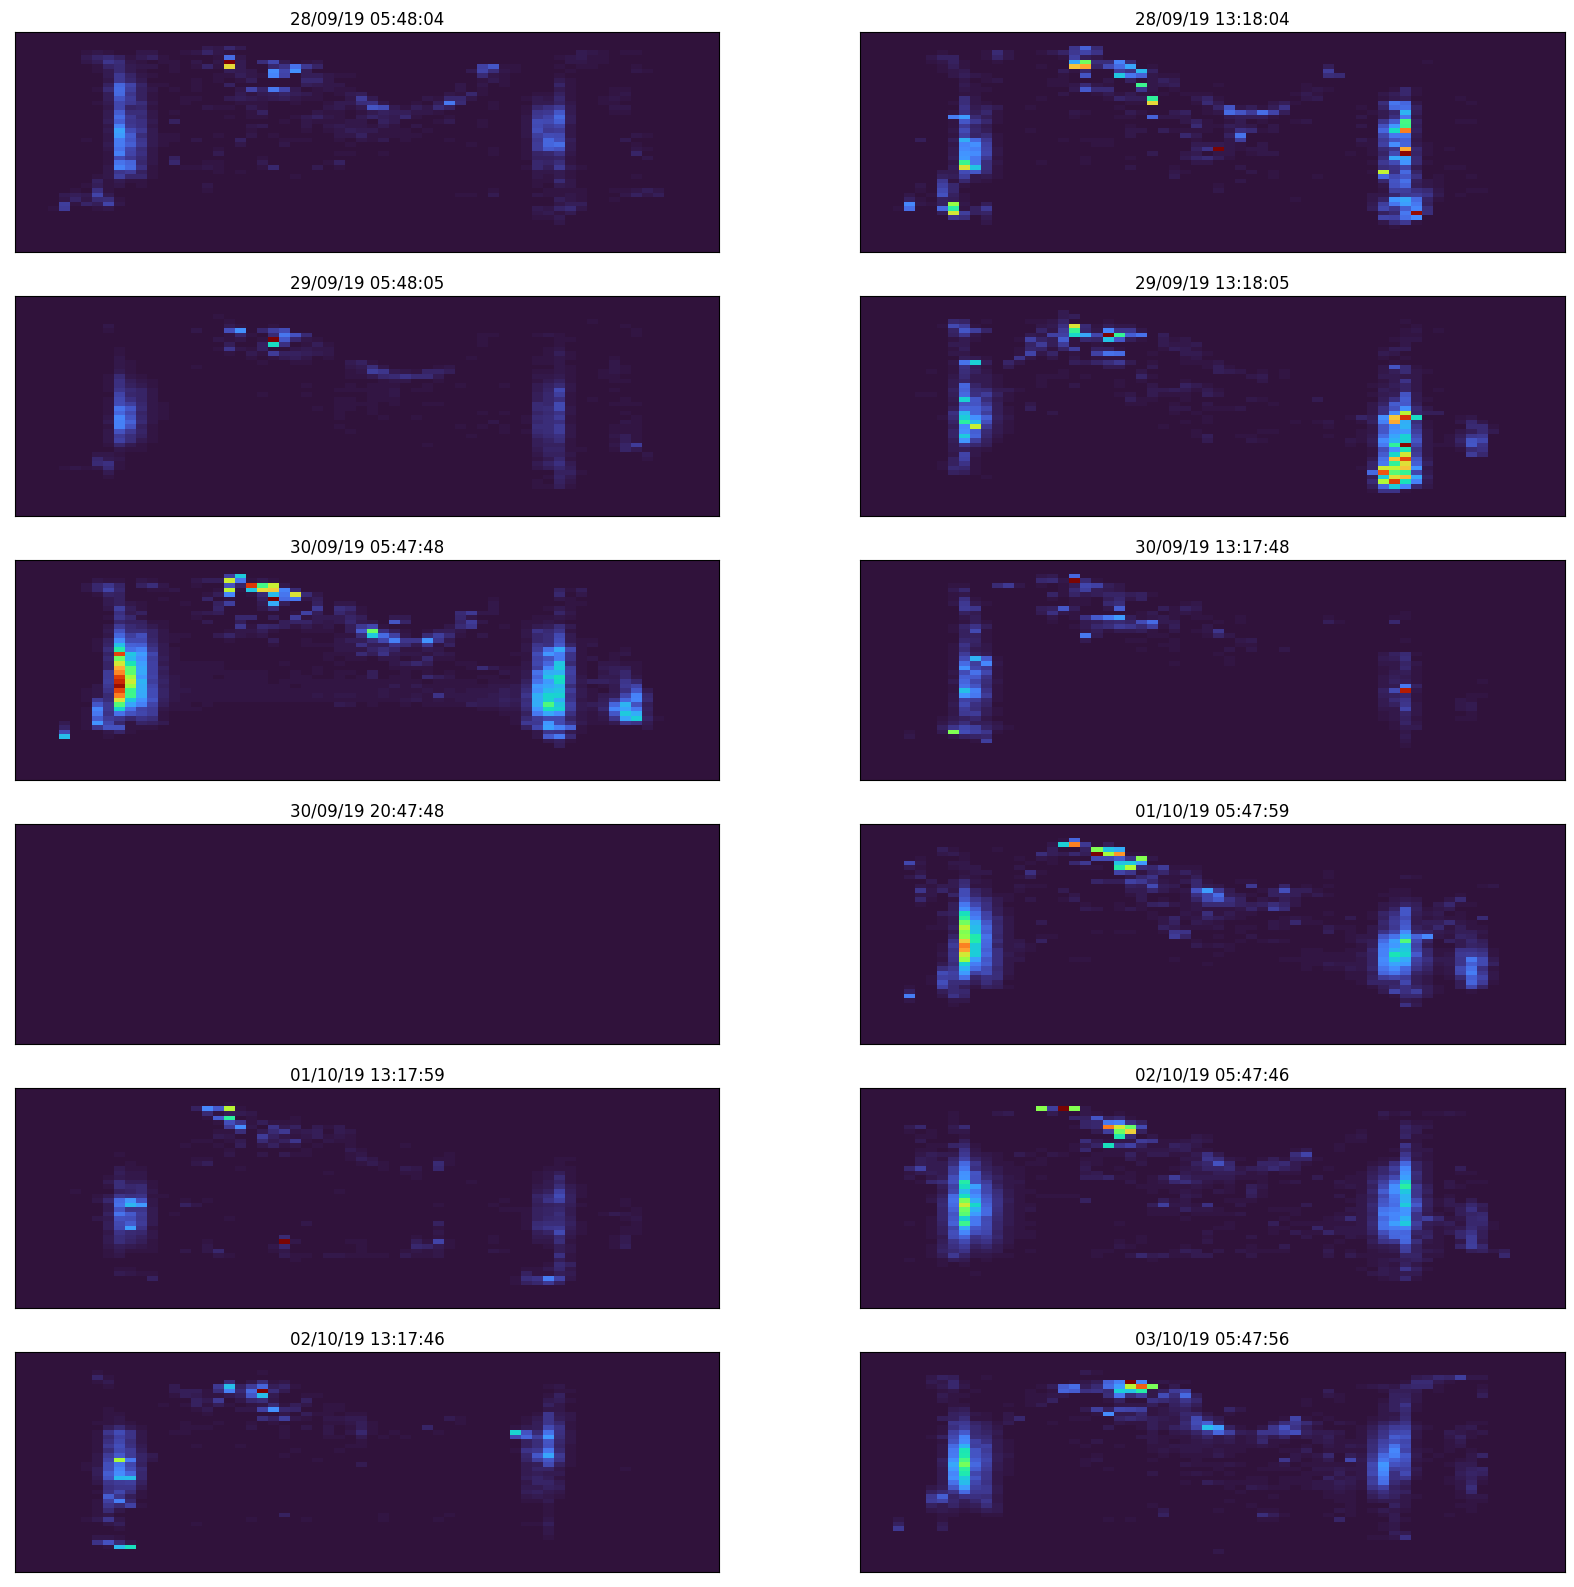

In [17]:
fig = plt.figure(figsize=(20, 20))

for i, value in enumerate(values):
    df = dataSet_all[dataSet_all["30m"] == value][["coord_x_cat", "coord_y_cat"]].dropna()

    ax = fig.add_subplot(6,2,i+1)
    ax.hist2d(df["coord_x_cat"], df["coord_y_cat"], bins=[x_cats, y_cats], cmap="turbo")
    ax.set_title(value)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

In [96]:
image_name = animal+"heatmap_7h30m"
fig.savefig(f'images/{image_name}.png', bbox_inches='tight', pad_inches=0)

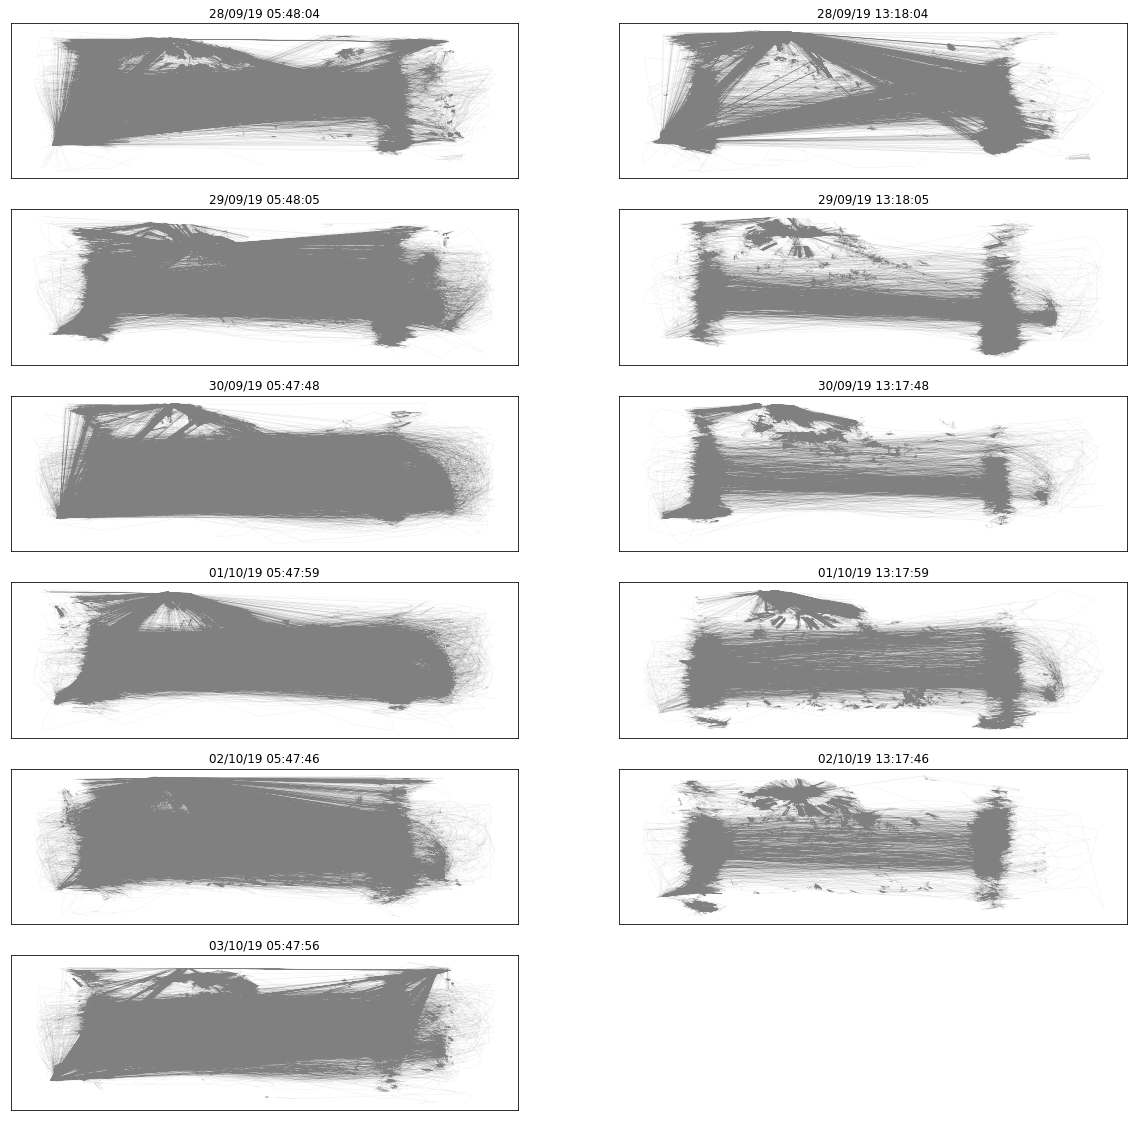

In [103]:
fig = plt.figure(figsize=(20, 20))

for i, value in enumerate(values):
    df = dataSet_all[dataSet_all["7h30m"] == value][["coord_x", "coord_y"]].replace([120.5, 120.5, 0], np.nan).dropna()

    ax = fig.add_subplot(6,2,i+1)
    ax.plot(df["coord_x"], df["coord_y"], linewidth = 0.05, color = "gray")
    ax.set_title(value)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlabel("")
    ax.set_ylabel("")

In [104]:
image_name = animal+"line_7h30m"
fig.savefig(f'images/{image_name}.png', bbox_inches='tight', pad_inches=0)

In [27]:
step = 5
y_cats = list(range(0,240+step, step))
x_cats = list(range(0,320+step, step))
y_labels = [(y_cats[i]+y_cats[i+1])/2 for i in range(len(y_cats)-1)]
x_labels = [(x_cats[i]+x_cats[i+1])/2 for i in range(len(x_cats)-1)]

Text(0, 0.5, '')

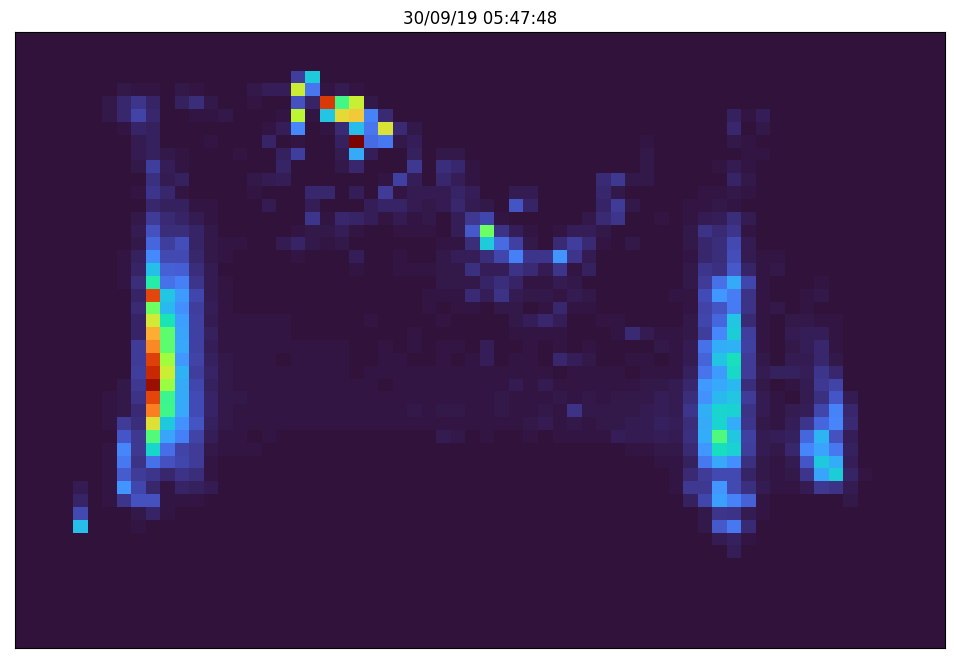

In [36]:
x = 4
group = "7h30m"
values = dataSet_all[group].dropna().unique()
values
df = dataSet_all[dataSet_all[group] == values[x]][["coord_x_cat", "coord_y_cat"]].dropna()
fig = plt.figure(figsize=(12,8))


ax = fig.add_subplot(1,1,1)
ax.hist2d(df["coord_x_cat"], df["coord_y_cat"], bins=[x_cats, y_cats], cmap="turbo")
ax.set_title(values[x])
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlabel("")
ax.set_ylabel("")

In [38]:
fig.savefig(f'{"teste"}.png', bbox_inches='tight', pad_inches=0)

In [2]:
"O343_04-Aug-2019 00_13_24.csv".replace("Aug", "")

'O343_04--2019 00_13_24'

In [4]:
from datetime import datetime

file = "O343_04-Aug-2019 00_13_24.csv"
datetime.strptime(file[len(file)-12:len(file)-4], "%H_%M_%S").time()

datetime.time(0, 13, 24)

In [1]:
from imutils.video import VideoStream
import argparseq
import datetime
import imutils
import time
import cv2

ModuleNotFoundError: No module named 'imutils'

In [2]:
!pip install imutils

In [ ]:
vs = cv2.VideoCapture(0)
# initialize the first frame in the video stream
firstFrame = None

while True:
    # grab the current frame and initialize the occupied/unoccupied
    # text
    frame = vs.read()
    frame = frame if args.get("video", None) is None else frame[1]
    text = "Unoccupied"
    # if the frame could not be grabbed, then we have reached the end
    # of the video
    if frame is None:
        break
    # resize the frame, convert it to grayscale, and blur it
    frame = imutils.resize(frame, width=500)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (21, 21), 0)
    # if the first frame is None, initialize it
    if firstFrame is None:
        firstFrame = gray
        continue

    # compute the absolute difference between the current frame and
    # first frame
    frameDelta = cv2.absdiff(firstFrame, gray)
    thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
    # dilate the thresholded image to fill in holes, then find contours
    # on thresholded image
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
        cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    # loop over the contours
    for c in cnts:
        # if the contour is too small, ignore it
        if cv2.contourArea(c) < args["min_area"]:
            continue
        # compute the bounding box for the contour, draw it on the frame,
        # and update the text
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
        text = "Occupied"

    # draw the text and timestamp on the frame
    cv2.putText(frame, "Room Status: {}".format(text), (10, 20),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
    cv2.putText(frame, datetime.datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
        (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
    # show the frame and record if the user presses a key
    cv2.imshow("Security Feed", frame)
    cv2.imshow("Thresh", thresh)
    cv2.imshow("Frame Delta", frameDelta)
    key = cv2.waitKey(1) & 0xFF
    # if the `q` key is pressed, break from the lop
    if key == ord("q"):
        break
# cleanup the camera and close any open windows
vs.stop() if args.get("video", None) is None else vs.release()
cv2.destroyAllWindows()

In [ ]:
def motion_detection():
    
    # construct the argument parser and parse the arguments
    ap = argparse.ArgumentParser()
    ap.add_argument("-v", "--video", help="path to the video file")
    ap.add_argument("-a", "--min-area", type=int, default=500, help="minimum area size")
    args = vars(ap.parse_args())
    # if the video argument is None, then we are reading from webcam
    if args.get("video", "None") is None:
        vs = VideoStream(src=0).start()
        time.sleep(2.0)
    # otherwise, we are reading from a video file
    else:
        vs = cv2.VideoCapture(args["video"])
    # initialize the first frame in the video stream
    firstFrame = None

    # loop over the frames of the video
    while True:
        # grab the current frame and initialize the occupied/unoccupied
        # text
        frame = vs.read()
        frame = frame if args.get("video", None) is None else frame[1]
        text = "Unoccupied"
        # if the frame could not be grabbed, then we have reached the end
        # of the video
        if frame is None:
            break
        # resize the frame, convert it to grayscale, and blur it
        frame = imutils.resize(frame, width=500)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray = cv2.GaussianBlur(gray, (21, 21), 0)
        # if the first frame is None, initialize it
        if firstFrame is None:
            firstFrame = gray
            continue
    
        # compute the absolute difference between the current frame and
        # first frame
        frameDelta = cv2.absdiff(firstFrame, gray)
        thresh = cv2.threshold(frameDelta, 25, 255, cv2.THRESH_BINARY)[1]
        # dilate the thresholded image to fill in holes, then find contours
        # on thresholded image
        thresh = cv2.dilate(thresh, None, iterations=2)
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        # loop over the contours
        for c in cnts:
            # if the contour is too small, ignore it
            if cv2.contourArea(c) < args["min_area"]:
                continue
            # compute the bounding box for the contour, draw it on the frame,
            # and update the text
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)
            text = "Occupied"
        
        # draw the text and timestamp on the frame
        cv2.putText(frame, "Room Status: {}".format(text), (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.putText(frame, datetime.datetime.now().strftime("%A %d %B %Y %I:%M:%S%p"),
            (10, frame.shape[0] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.35, (0, 0, 255), 1)
        # show the frame and record if the user presses a key
        cv2.imshow("Security Feed", frame)
        cv2.imshow("Thresh", thresh)
        cv2.imshow("Frame Delta", frameDelta)
        key = cv2.waitKey(1) & 0xFF
        # if the `q` key is pressed, break from the lop
        if key == ord("q"):
            break
    # cleanup the camera and close any open windows
    vs.stop() if args.get("video", None) is None else vs.release()
    cv2.destroyAllWindows()
                


if __name__=='__main__':    
    motion_detection()